
# Influence of 14N on 13C NMR MAS spectra of glycine


> This notebook contains code adapted from the mrsimulator examples repository (https://github.com/mrsimulator/mrsimulator).
> See LICENSE-THIRD-PARTY.md for the BSD 3-Clause license details.

The alpha-carbon resonance of glycine, 13C (I=1/2), attached to 14N (I=1).
The 14N quadrupolar tensor parameters were obtained from Hexem et al. [1](#f1).


In [22]:
import matplotlib.pyplot as plt
import numpy as np

from mrsimulator import Simulator, SpinSystem, Site, Coupling
from mrsimulator.method.lib import BlochDecaySpectrum
from mrsimulator import signal_processor as sp
from mrsimulator.spin_system.tensors import SymmetricTensor
from mrsimulator.method import SpectralDimension

Create a 13C-14N coupled spin system.



In [ ]:
from ase.io import read
from soprano.selection import AtomSelection
from soprano.properties.nmr import get_spin_system

# atoms = read("../example_data/glycine/nmr/glycine.magres")
atoms = read("../example_data/glycine/crystalline/glycin25_nmr.magres")
# Get relevant subset
CN_sel = AtomSelection(atoms, [12,14]) # C2 and N1
atoms = CN_sel.subset(atoms)

# Extract spin system in MRSimulator format
magres_spin_system = get_spin_system(
            atoms,
            include_shielding=False,
            include_efg=True,
            include_dipolar=True,
            ).to_mrsimulator()


In [66]:
magres_spin_system


{'sites': [{'isotope': '13C', 'label': 'C2'},
  {'isotope': '14N',
   'label': 'N1',
   'quadrupolar': {'Cq': 1495258.3309293762,
    'eta': 0.4769699014926341,
    'alpha': 2.512614665384554,
    'beta': 1.5355747234113313,
    'gamma': 1.5228273584100065}}],
 'couplings': [{'dipolar': {'D': -680.4752305595654,
    'alpha': 2.6230298687793088,
    'beta': 1.4629026832760956,
    'gamma': 0.0},
   'site_index': [0, 1]}]}

In [67]:
print(SpinSystem.parse_obj(magres_spin_system))

name=None description=None label=None property_units={'abundance': 'pct'} sites=[Site(name=None, description=None, label='C2', property_units={'isotropic_chemical_shift': 'ppm'}, isotope=Isotope(symbol='13C'), isotropic_chemical_shift=0.0, shielding_symmetric=None, shielding_antisymmetric=None, quadrupolar=None), Site(name=None, description=None, label='N1', property_units={'isotropic_chemical_shift': 'ppm'}, isotope=Isotope(symbol='14N'), isotropic_chemical_shift=0.0, shielding_symmetric=None, shielding_antisymmetric=None, quadrupolar=SymmetricTensor(name=None, description=None, label=None, property_units={'Cq': 'Hz', 'alpha': 'rad', 'beta': 'rad', 'gamma': 'rad'}, zeta=None, Cq=1495258.3309293762, D=None, eta=0.4769699014926341, alpha=2.512614665384554, beta=1.5355747234113313, gamma=1.5228273584100065))] couplings=[Coupling(name=None, description=None, label=None, property_units={'isotropic_j': 'Hz'}, site_index=[0, 1], isotropic_j=0.0, j_symmetric=None, j_antisymmetric=None, dipola

In [68]:
spin_system = SpinSystem(
    sites=[
        Site(isotope="13C", isotropic_chemical_shift=0.0),
        Site(
            isotope="14N",
            isotropic_chemical_shift=0,  # in ppm
            quadrupolar=SymmetricTensor(
                Cq=1.18e6,  # in Hz
                eta=0.54,
                alpha=0,
                beta=5 * np.pi / 180,
                gamma=0,
            ),
        ),
    ],
    couplings=[Coupling(site_index=[0, 1], dipolar=SymmetricTensor(D=-660.2))],
)

Create a BlochDecaySpectrum method.



In [69]:
method = BlochDecaySpectrum(
    channels=["13C"],
    magnetic_flux_density=3.5338,  # in T
    rotor_frequency=12000,  # in Hz
    spectral_dimensions=[SpectralDimension(count=2048, spectral_width=200)],
)

Create the Simulator object and add the method and the spin system object.



In [70]:
magres_sim = Simulator(spin_systems=[magres_spin_system], methods=[method])
sim = Simulator(spin_systems=[spin_system], methods=[method])

magres_sim.config.integration_volume = "hemisphere"
sim.config.integration_volume = "hemisphere"


magres_sim.run()
sim.run()

Add post-simulation signal processing.



In [71]:
processor = sp.SignalProcessor(
    operations=[
        sp.IFFT(),
        sp.apodization.Gaussian(FWHM="1 Hz"),
        sp.FFT(),
    ]
)

magres_processed_dataset = processor.apply_operations(dataset=magres_sim.methods[0].simulation)
magres_processed_dataset.dimensions[0].to("Hz")

processed_dataset = processor.apply_operations(dataset=sim.methods[0].simulation)
processed_dataset.dimensions[0].to("Hz")

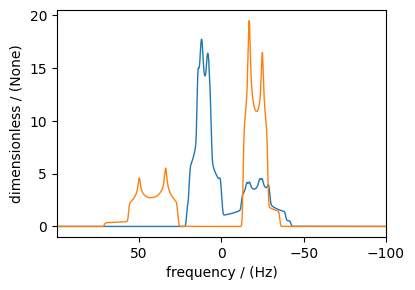

In [74]:
plt.figure(figsize=(4.25, 3.0))
ax = plt.subplot(projection="csdm")
ax.plot(magres_processed_dataset.real, color="C0", linewidth=1)
ax.plot(processed_dataset.real, color="C1", linewidth=1)
ax.invert_xaxis()
plt.tight_layout()
plt.show()

## References

[1] Hexem, J. G., Frey, M. H., and Opella, S. J., Influence of
     $^{14}\text{N}$ on $^{13}\text{C}$ NMR Spectra of Solids, J. Am.
     Chem. Soc., 1981, **103**, 224-226.
     [DOI: 10.1021/ja00391a057](https://doi.org/10.1021/ja00391a057)

